# POS Tagging

Build a multiclass classifier to predict the POS tag of each word. Use a sliding window, i.e. represent each word by the concatenation of the embeddings of 5 words, i.e. the word, two preceding and two following words. Add a special padding word to the embeddings to represent words close to the beginning or end of a sentence.

Get the Brown corpus.

In [1]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /home/medialab/attardi/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Get the tokenized and tagged with Universal POS sentences from the "news" category from the Brown corpus:

In [2]:
from nltk.corpus import brown
nltk.download('universal_tagset')
brown_sents = brown.tagged_sents(categories='news', tagset='universal')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/medialab/attardi/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


See an example

In [3]:
brown_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

## Split into train and test
Use all but the last 1000 sentences to train the classifier. (It should be better to choose them randomly).

In [4]:
brown_train = brown_sents[:-1000]
brown_test = brown_sents[-1000:]

## Build dictionary of words and tags

Vocabularies of words and tags:

In [5]:
word_set = set()
tag_set = set()
for sentence in brown_sents:
    for word, tag in sentence:
        word_set.add(word)
        tag_set.add(tag)

Dictionaries of words and tags:

In [6]:
word_index = {word: idx + 2 for idx, word in enumerate(word_set)} # + 2 leave 0 and 1 for padding and unknown
    
tag_index = {tag: idx for idx,tag in enumerate(tag_set)}
idx2tag = list(tag_set)

n_words = len(word_index) + 2 # for padding and OOV
n_tags = len(tag_set)

See the tag set of Universal Dependencies:

In [7]:
print(idx2tag)

['NOUN', 'CONJ', '.', 'PRT', 'ADJ', 'VERB', 'DET', 'X', 'PRON', 'NUM', 'ADV', 'ADP']


## Data representation

We will use a Neural Net classifier for POS tagging.

In order to provide some context for the classifer, we represent each token as an n-gram of 5 tokens, considering 2 tokens on the left and 2 on the right.

In [8]:
import numpy as np

def build_ngrams(sentences, ctx_size, word_index, tag_index):
    """
    Turn sentences into n-grams of word indices, taken from word_index.
    :param sentences: a list of sentences.
    :param ctx_size: numer of tokens to consider before and after each word.
    :param word_index: dictionary of words.
    :param tag_index: dictionary of tags.
    :return: the list of n-grams and the list of corresponding labels.
    """
    padding_idx = 0
    unknown_idx = 1
    
    X = []
    Y = []
    
    for sentence in sentences:
        for n, (word, tag) in enumerate(sentence):
            word_indices = []
            for i in range(n - ctx_size, n + ctx_size + 1):
                # add padding
                if i < 0 or i >= len(sentence):
                    word_indices.append(padding_idx)
                    continue
                gram = sentence[i][0]
                # index of either word, lowercase word or unknown
                word_idx = word_index.get(gram) or word_index.get(gram.lower(),
                                                                  unknown_idx)
                word_indices.append(word_idx)

            X.append(word_indices)
            Y.append(tag_index[tag])
            
    return np.asarray(X), np.asarray(Y)                    

## Build the data set of n-grams

In [9]:
ctx_size = 2
window_size = 2 * ctx_size + 1
x_train_ng, y_train = build_ngrams(brown_train, ctx_size, word_index, tag_index)
x_test_ng, y_test = build_ngrams(brown_test, ctx_size, word_index, tag_index)

In [10]:
x_train_ng.shape, y_train.shape, x_test_ng.shape, y_test.shape

((77552, 5), (77552,), (23002, 5), (23002,))

In [11]:
x_train_ng[:3]

array([[   0,    0, 1825, 4989, 9060],
       [   0, 1825, 4989, 9060, 7517],
       [1825, 4989, 9060, 7517, 7503]])

## NN Classifier

The NN classifier will produce a probability distribution for each tag:

   $P(t_{i,j}|w_{i-2}w_{i-1}w_iw_{i+1}w_{i+2}) = softmax(W\cdot [E(w_{i-2})...E(w_{i+2}] + b))$

where $E(w)$ is the embedding for word $w$.

The predicted output will be the tag with the highest probability, i.e.:

   $y_i = argmax_{j}P(t_{i,j}|w_{i-2}...w_{i+2})$

The output of the classifier should be a vector of size as the number of possible tags.
We can obtain this using function `to_categorical`, to turn tag indices into a one-hot representation:

In [12]:
from tensorflow.keras.utils import to_categorical
to_categorical?

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Signature: to_categorical(y, num_classes=None, dtype='float32')
Docstring:
Converts a class vector (integers) to binary class matrix.

E.g. for use with `categorical_crossentropy`.

Args:
    y: Array-like with class values to be converted into a matrix
        (integers from 0 to `num_classes - 1`).
    num_classes: Total number of classes. If `None`, this would be inferred
      as `max(y) + 1`.
    dtype: The data type expected by the input. Default: `'float32'`.

Returns:
    A binary matrix representation of the input. The class axis is placed
    last.

Example:

>>> a = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
>>> a = tf.constant(a, shape=[4, 4])
>>> print(a)
tf.Tensor(
  [[1. 0. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 1. 0.]
   [0. 0. 0. 1.]], shape=(4, 4), dtype=float32)

>>> b = tf.constant([.9, .04, .03, .03,
...                  .3, .45, .15, .13,
...                  .04, .01, .94, .05,
...                  .12, .21, .5, .17],
...                 shape=[4, 4])


Convert tags into one-hot representation:

In [13]:
y_train_cat = to_categorical(y_train, num_classes=n_tags)

See one result in categorical form:

In [14]:
y_train[5], y_train_cat[5]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32))

### Build the model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.losses import categorical_crossentropy

Hyperparameters

In [16]:
MAX_SEQUENCE_LENGTH = 250
HIDDEN_SIZE = 128
EMBEDDING_DIM = 50
EPOCHS = 4
BATCH_SIZE = 64

In [17]:
model_nn = Sequential()
model_nn.add(Embedding(n_words, EMBEDDING_DIM, input_length=window_size))
model_nn.add(Flatten())
model_nn.add(Dropout(0.2)) # optional
model_nn.add(Dense(HIDDEN_SIZE, activation='relu'))
model_nn.add(Dropout(0.2)) # optional
model_nn.add(Dense(n_tags, activation='softmax'))
model_nn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

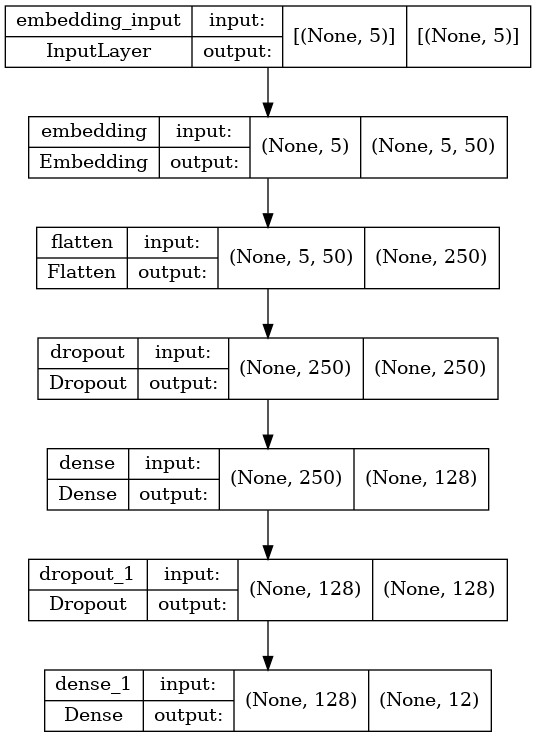

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(model_nn, show_shapes=True)

### Train the model

In [19]:
history = model_nn.fit(x_train_ng, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/4
1212/1212 [==============================] - 9s 7ms/step - loss: 0.5250 - accuracy: 0.8484
Epoch 2/4
1212/1212 [==============================] - 8s 7ms/step - loss: 0.0925 - accuracy: 0.9731
Epoch 3/4
1212/1212 [==============================] - 8s 7ms/step - loss: 0.0411 - accuracy: 0.9880
Epoch 4/4
1212/1212 [==============================] - 8s 7ms/step - loss: 0.0230 - accuracy: 0.9933


### Evaluate the tagger

Call `predict` to obtain a probability distribution for the classes and then take the `argmax`:

In [20]:
tag_prob_ng = model_nn.predict(x_test_ng)
y_pred_ng = tag_prob_ng.argmax(1)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def show_accuracy(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred) * 100
    pr = precision_score(y_test, y_pred, average='macro', zero_division=0) * 100
    rc = recall_score(y_test, y_pred, average='macro', zero_division=0) * 100
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0) * 100
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f, F1: %.2f" %
          (acc, pr, rc, f1))

In [22]:
show_accuracy([idx2tag[i] for i in y_test], [idx2tag[i] for i in y_pred_ng])

Accuracy: 93.37, Precision: 94.97, Recall: 85.00, F1: 87.00


In [23]:
from sklearn.metrics import classification_report
print(classification_report([idx2tag[i] for i in y_test], [idx2tag[i] for i in y_pred_ng], digits=4, zero_division=0))

              precision    recall  f1-score   support

           .     1.0000    1.0000    1.0000      2898
         ADJ     0.8656    0.7547    0.8063      1818
         ADP     0.9646    0.9699    0.9673      2895
         ADV     0.9033    0.8318    0.8661       999
        CONJ     0.9911    0.9926    0.9918       673
         DET     0.9930    0.9941    0.9936      2712
        NOUN     0.8840    0.9510    0.9163      5984
         NUM     0.9795    0.8093    0.8863       472
        PRON     0.9834    0.9769    0.9802       607
         PRT     0.9174    0.8898    0.9034       599
        VERB     0.9144    0.9083    0.9113      3304
           X     1.0000    0.1220    0.2174        41

    accuracy                         0.9337     23002
   macro avg     0.9497    0.8500    0.8700     23002
weighted avg     0.9341    0.9337    0.9325     23002



### Show the confusion matrix

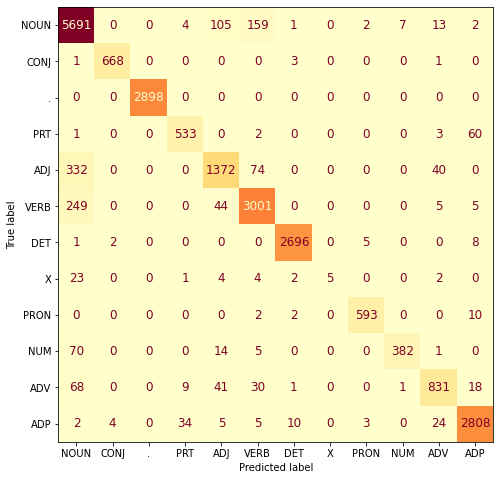

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 12})

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ng,
                                        display_labels=tag_set, cmap='YlOrRd',
                                        colorbar=False, ax=ax)

## POS Tagger with Conv1D
Instead of creating the ngrams explicitly, one could use a `Conv1D` layer to group tokens. 

In [25]:
unknown_idx = 1
x_train_cnn = [[word_index.get(word, word_index.get(word.lower(), unknown_idx))
            for word,tag in sentence] for sentence in brown_train]
y_train_cnn = [[tag_index[tag] for word,tag in sentence]
                                       for sentence in brown_train]
x_test_cnn = [[word_index.get(word, word_index.get(word.lower(), unknown_idx))
                    for word,tag in sentence] for sentence in brown_test]
y_test_cnn = [[tag_index[tag] for word,tag in sentence]
                                       for sentence in brown_test]

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tag_pad = n_tags # use this value to distinguish pad in tags

x_train_cnn = pad_sequences(x_train_cnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
x_test_cnn = pad_sequences(x_test_cnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_train_cnn = pad_sequences(y_train_cnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post',
                          value=tag_pad)
y_test_cnn = pad_sequences(y_test_cnn, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post',
                          value=tag_pad)

In [28]:
y_train_cnn_cat = to_categorical(y_train_cnn, num_classes=n_tags+1) # <PAD>

### Build the model

In [29]:
filters = 250 #HIDDEN_SIZE

from tensorflow.keras.layers import Conv1D

model_cnn = Sequential()
model_cnn.add(Embedding(n_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_cnn.add(Conv1D(filters, window_size, padding='same', activation='relu'))
model_cnn.add(Dense(HIDDEN_SIZE, activation='relu'))
model_cnn.add(Dropout(0.2)) # optional
model_cnn.add(Dense(n_tags+1, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

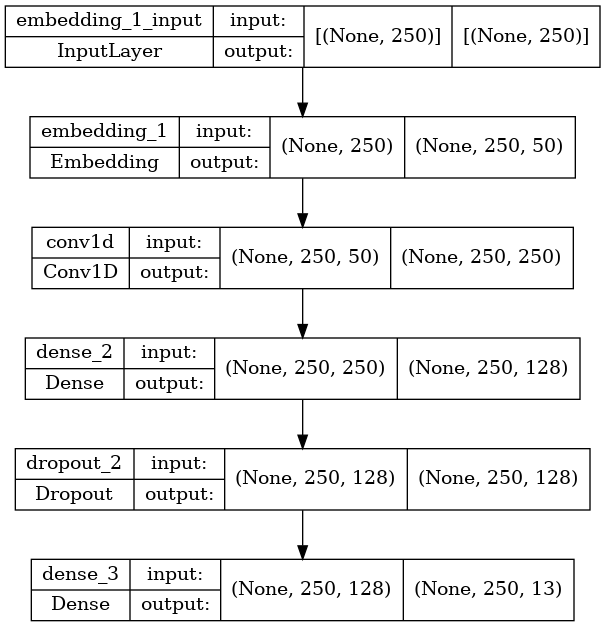

In [30]:
plot_model(model_cnn, show_shapes=True)

In [31]:
history = model_cnn.fit(x_train_cnn, y_train_cnn_cat, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/4
57/57 [==============================] - 5s 87ms/step - loss: 0.7362 - accuracy: 0.9256
Epoch 2/4
57/57 [==============================] - 5s 85ms/step - loss: 0.0791 - accuracy: 0.9782
Epoch 3/4
57/57 [==============================] - 5s 84ms/step - loss: 0.0286 - accuracy: 0.9919
Epoch 4/4
57/57 [==============================] - 5s 84ms/step - loss: 0.0119 - accuracy: 0.9969


In [32]:
tag_pred_cnn = model_cnn.predict(x_test_cnn)
y_pred_cnn = tag_pred_cnn.argmax(2)

Remove pads (somewhat arbitrarily assign them to X):

In [33]:
y_pred_cnn = [[pred[i] if pred[i] != tag_pad else tag_index['X'] for i,t in enumerate(gold) if t != tag_pad] for gold,pred in zip(y_test_cnn,y_pred_cnn)]
y_pred_cnn_flat = [item for sublist in y_pred_cnn for item in sublist]

In [34]:
show_accuracy(y_test, y_pred_cnn_flat)

Accuracy: 92.25, Precision: 91.22, Recall: 81.93, F1: 84.51


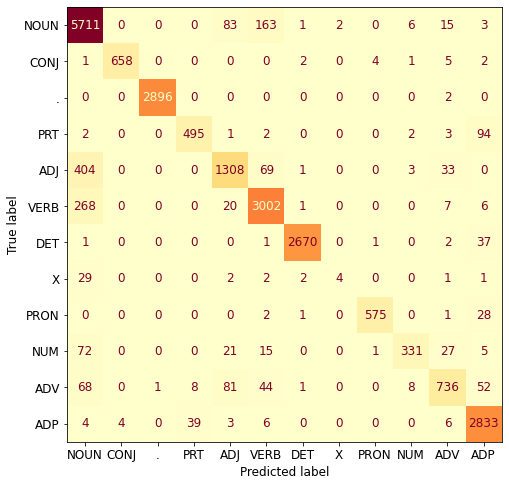

In [35]:
fig_cnn, ax_cnn = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 12})
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cnn_flat, cmap='YlOrRd',
                                        display_labels=tag_set, colorbar=False, ax=ax_cnn)

# Classification report

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report([idx2tag[i] for i in y_test], [idx2tag[i] for i in y_pred_cnn_flat],
                            digits=4, zero_division=0))

              precision    recall  f1-score   support

           .     0.9997    0.9993    0.9995      2898
         ADJ     0.8611    0.7195    0.7839      1818
         ADP     0.9255    0.9786    0.9513      2895
         ADV     0.8783    0.7367    0.8013       999
        CONJ     0.9940    0.9777    0.9858       673
         DET     0.9966    0.9845    0.9905      2712
        NOUN     0.8706    0.9544    0.9106      5984
         NUM     0.9430    0.7013    0.8044       472
        PRON     0.9897    0.9473    0.9680       607
         PRT     0.9133    0.8264    0.8677       599
        VERB     0.9080    0.9086    0.9083      3304
           X     0.6667    0.0976    0.1702        41

    accuracy                         0.9225     23002
   macro avg     0.9122    0.8193    0.8451     23002
weighted avg     0.9226    0.9225    0.9203     23002



## HMM Tagger

In [38]:
from nltk.tag.hmm import HiddenMarkovModelTrainer

In [39]:
tag_set = list(set((tag for sent in brown_train for word,tag in sent)))
symbols = list(set((word for sent in brown_train for word,tag in sent)))

### Train the HMM

In [40]:
trainer = HiddenMarkovModelTrainer(tag_set, symbols)
hmm = trainer.train(brown_train)

### Test the HMM

In [41]:
hmm.test(brown_test, verbose=False)

accuracy over 23002 tokens: 46.58


# POS Tagger based on Maximum Entropy Markov Model 

In [42]:
import numpy as np
import re
from nltk.classify.maxent import MaxentClassifier

### The feature extractor
The MaxEnt classifiers relies on hand crafted feature representations for the input words.

The features we use:
<ul>
    <li>morphological aspects of English words, e.g. words ending in 'ed', 'ing', or 'ly'</li>
    <li>capitalization, not at the beginning of a sentence</li>
    <li>presence of the word in a list of closed POS categories, e.g. 'CONJ', 'DET', 'PRON', 'PRT</li>
    <li>aspects of the previos word: e.g capitalization, particle</li>
</ul>
You can think of many such features.

Until a few years ago, the SoTA POS taggers were using a rich feature set. See for example:

Giménez, J., and Márquez, L. 2004. [SVMTool: A general POS tagger generator based on Support Vector Machines](https://www.cs.upc.edu/~nlp/SVMTool/lrec2004-gm.pdf]). Proceedings of LREC'04. Lisbon, Portugal.

Compute the most common suffixes:

In [43]:
suffix_fdist = nltk.FreqDist()
for word in brown.words():
     word = word.lower()
     suffix_fdist[word[-2:]] += 1
     suffix_fdist[word[-3:]] += 1

common_suffixes = [suffix for (suffix, count) in suffix_fdist.most_common(20)]

In [44]:
print(common_suffixes)

[',', '.', 'he', 'of', 'the', 'to', 'in', 'a', 'ed', 'nd', 'is', 'on', 'and', 'ng', 'er', 'as', 'ing', 'at', 'es', 'or']


Collects the feature of a word at position n in a sentence

In [45]:
def features_dict(word, prev_word, prev_tag, n, lexicon):
    """
    :param word: the current word
    :param prev_word: the preceding word, or None if it soes not exist
    :param prev_tag: the tag of the previous word
    :param n: the position of the wird in the sentence
    :param lexicon: a lexicon of POS for each word
    :return: a dictionary of features {feature: value}
    """
    word = word.lower()
    prev_word = prev_word.lower() if prev_word else ''
    DET = lexicon['DET']
    CONJ = lexicon['CONJ']
    PRON = lexicon['PRON']
    PRT = lexicon['PRT']

    features = {
        'wi': word,
        'wi-1': prev_word,
        'CurCap': is_cap(word),
        'FirstWord': n == 0,
        'HasNumb': has_number(word),
        'Article': word in DET,
        'PrevArticle': prev_word in DET,
        'Conj': word in CONJ,
        'Pron': word in PRON,
        'Prt': word in PRT,
        'PrevConj': prev_word in CONJ,
        'PrevPrt': prev_word in PRT,
        'PrevTag': prev_tag   # required to compute transition probabilities
    }
    for suffix in common_suffixes:
        if word.endswith(suffix):
            features[f'endswith({suffix})'] = 1
    # presence in given POS list
    for tag, words in lexicon.items():
        if word in words:
            features[tag] = 1
    return features

Features

In [46]:
def is_cap(word):
    return word[0].isupper()

def has_number(word):
    return re.search(r'\d+', word) is not None

In [47]:
def create_featuresets(sentence, lexicon):
    """
    Build a featureset for each token in a sentence, for use in training a MaxentClassifier.
    :param sentence: a list of pairs (word, tag).
    :return: a list of pairs (featurset, tag)
    """
    for n, (word, tag) in enumerate(sentence):
        prev_word, prev_tag = sentence[n-1] if n > 0 else (None, None)
        yield (features_dict(word, prev_word, prev_tag, n, lexicon), tag)


Build lexicons for a certain closed classes of POS. We will use the presence in such lexicon as a feature.

In [48]:
from collections import defaultdict

def create_lexicon(trainset, tags=('ADV', 'DET', 'PRON', 'PRT')):
    """
    Build lexicon of words belonging to specific closed categories.
    """
    lexicon = defaultdict(set)
    for sent in trainset:
        for w,t in sent:
            if t in tags:
                lexicon[t].add(w)
    return lexicon

## MaxEntropy Markov Model Tagger

In [49]:
from nltk.classify.maxent import MaxentClassifier

class MemmTagger():
    
    def __init__(self, trainset, max_iter=20):
        """
        :param trainset: list of sentences, each a list of pairs (word, tag)
        """
        self.tags = list(set((tag for sent in trainset for word,tag in sent)))
        self.lexicon = create_lexicon(trainset)
        self.featuresets = [pair for sentence in trainset for pair in create_featuresets(sentence, self.lexicon)]
        self.classifier = MaxentClassifier.train(self.featuresets, max_iter=max_iter)
    
    def tag(self, sentence):
        """
        :param sentence: list of pairs (word, tag)
        """
        tags = self.viterbi(sentence)
        return list(zip(sentence, tags))
    
    def viterbi(self, words):
        """
        Returns the tag sequence of the optimal (most probable) path through
        the MEMM. Uses the Viterbi algorithm to calculate this path by dynamic
        programming.

        :return: the tag sequence
        :rtype: sequence of any
        :param words: the sequence of words
        :type words: list of pairs (word, tag)
        """
        T = len(words)
        N = len(self.tags)

        V = np.zeros((T, N), np.float32)
        B = -np.ones((T, N), np.int)

        featuresets = list(create_featuresets(words, self.lexicon))
        P = [ self.classifier.prob_classify(featureset) for (featureset, label) in featuresets ]
        return [x.max() for x in P] # DEBUG

        # the forward probability: s1 = previous label, s2 = next label
        # A[t, s2] = Sum{s1} A[t-1, s1] * p(s2| s1,o_t)
        # P[t/s1].prob(s2) = p(s2| s1,o_t)
        # where P[t/s1] is the dist prob at t if previous tag was s1
        # A[t, s2] = sum(A[t-1, s1] * P[t/s1].prob(s2) forall s1)
        A = np.zeros(N)
        for s in range(N):
            A[s] = P[0].logprob(s)
                
        V[0] = A
        for t in range(1, T):
            # build transition probabilities
            A1 = np.zeros(N)
            for s in range(N):
                A1[s] = sum([A[s1] + self.prob_from_tag(featuresets[t][0], s1).logprob(s) for s1 in range(N)])
            A = A1
            for s in range(N):
                vs = V[t - 1, :] + A
                best = np.argmax(vs)
                V[t, s] = vs[best] + P[t].logprob(s)
                B[t, s] = best

        # backtrace:
        current = np.argmax(V[T - 1, :])
        tags = [current]
        for t in range(T - 1, 0, -1):
            last = B[t, current]
            tags.insert(0, last)
            current = last

        return list(map(self.tags.__getitem__, tags))

                            
    def prob_from_tag(self, featureset, prev_tag):
        """
        Calculate the probability distribution of featureset when the previous tag is :param prev_tag:
        """
        cur_tag = featureset['PrevTag'] # save gold
        featureset['PrevTag'] = self.tags[prev_tag] # predicted
        prob_dist = self.classifier.prob_classify(featureset)
        featureset['PrevTag'] = cur_tag # restore gold
        return prob_dist

## Train the Maximum Entropy Markov Model

<b>Warning</b>: training is quite slow.

In [50]:
tagger = MemmTagger(brown_train, max_iter=20)

  ==> Training (20 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -2.48491        0.001
             2          -1.35686        0.531
             3          -1.09917        0.637
             4          -0.93441        0.731
             5          -0.81685        0.804
             6          -0.72837        0.840
             7          -0.65944        0.857
             8          -0.60426        0.870
             9          -0.55907        0.884
            10          -0.52133        0.894
            11          -0.48927        0.903
            12          -0.46165        0.913
            13          -0.43755        0.919
            14          -0.41630        0.924
            15          -0.39739        0.929
            16          -0.38043        0.936
            17          -0.36510        0.940
            18          -0.35117        0.943
            19          -0.33843        0.946
  

In [51]:
tagger.tag(brown_test[1])

<ipython-input-49-e29a1cccf0bc>:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  B = -np.ones((T, N), np.int)


[(('Mollusks', 'NOUN'), 'NOUN'),
 (('are', 'VERB'), 'VERB'),
 (('a', 'DET'), 'DET'),
 (('case', 'NOUN'), 'NOUN'),
 (('in', 'ADP'), 'ADP'),
 (('point', 'NOUN'), 'NOUN'),
 (('.', '.'), '.')]

In [52]:
tag_pred = [tagger.tag(sent) for sent in brown_test]

<ipython-input-49-e29a1cccf0bc>:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  B = -np.ones((T, N), np.int)


In [53]:
print(classification_report([x[1] for s in brown_test for x in s], [x[1] for s in tag_pred for x in s], digits=4,
                           zero_division=True))

              precision    recall  f1-score   support

           .     0.9715    0.8813    0.9242      2898
         ADJ     0.8725    0.5121    0.6454      1818
         ADP     0.9089    0.8653    0.8866      2895
         ADV     0.9117    0.7237    0.8069       999
        CONJ     0.9865    0.8692    0.9242       673
         DET     0.9943    0.9687    0.9813      2712
        NOUN     0.7579    0.9714    0.8515      5984
         NUM     0.9586    0.6377    0.7659       472
        PRON     0.9858    0.9160    0.9496       607
         PRT     0.7570    0.8631    0.8066       599
        VERB     0.8989    0.8938    0.8963      3304
           X     1.0000    0.1463    0.2553        41

    accuracy                         0.8726     23002
   macro avg     0.9170    0.7707    0.8078     23002
weighted avg     0.8849    0.8726    0.8693     23002



# Conclusions

Draw your conclusions about sequence tagging using either plain NN, NN with embrddings, CNN or Maximum Entropy using hand crafted features.

In [ ]:
# Why the classifer returns always 0?
sent = brown_train[0]
featuresets = create_featuresets(sent, tagger.lexicon)
P = [ tagger.classifier.prob_classify(featureset) for (featureset, label) in featuresets ]
[P[1].prob(i) for i in range(len(tagger.tags))]